# Dataloader


In [29]:
import numpy as np
from torch import nn
import torch
from torch import optim
import torchvision
from torchvision import models
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder

from torchvision.datasets import DatasetFolder
from PIL import Image

T = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# dataset = ImageFolder("../data/animals-10/raw-img/", transform=T)

# train_set, val_set = random_split(
#     dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)]
# )

# train_loader = DataLoader(train_set, batch_size=64)
# test_loader = DataLoader(val_set, batch_size=64)


# Custom loader for ImageFolder
def pil_loader(path):
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")


# Optimized DatasetFolder using custom loader
dataset = DatasetFolder(
    root="../data/animals-10/raw-img/",
    loader=pil_loader,
    extensions=("jpg", "jpeg", "png"),
    transform=T,
)

# Split dataset
train_set, val_set = random_split(
    dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)]
)

# Optimized DataLoader with multi-threading and pinned memory
train_loader = DataLoader(train_set, batch_size=64, num_workers=16, pin_memory=True)
test_loader = DataLoader(val_set, batch_size=64, num_workers=16, pin_memory=True)

# ResNet18


In [30]:
res_18_model = models.resnet18(pretrained=True)

res_18_model.fc = nn.Linear(512, 10)

model = res_18_model


if torch.cuda.is_available() == True:
    model = res_18_model.cuda()

optimiser = optim.SGD(model.parameters(), lr=1e-2)
loss = nn.CrossEntropyLoss()

# My training and validation loops
nb_epochs = 4
acc_tot = np.zeros(nb_epochs)
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()
    model.train()
    for x, y in train_loader:

        if torch.cuda.is_available() == True:
            x = x.cuda()
            y = y.cuda()

        # 1 forward
        l = model(x)

        # 2 compute the cost function
        J = loss(l, y)

        # 3 cleaning the gradients
        model.zero_grad()
        # optimiser.zero_grad()
        # params.grad.zero_()

        # 4 accumulate the partial derivatives of J wrt params
        J.backward()

        # 5 step in the opposite direction of the gradient
        optimiser.step()

        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1)).float().mean())

    print(f"Epoch {epoch + 1}", end=", ")
    print(f"training loss: {torch.tensor(losses).mean():.2f}", end=", ")
    print(f"training accuracy: {torch.tensor(accuracies).mean():.2f}")

Epoch 1, training loss: 0.36, training accuracy: 0.91
Epoch 2, training loss: 0.12, training accuracy: 0.97
Epoch 3, training loss: 0.07, training accuracy: 0.98
Epoch 4, training loss: 0.05, training accuracy: 0.99


In [31]:
def imformat(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [32]:
class_names = dataset.classes
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "dog": "cane",
    "cavallo": "horse",
    "elephant": "elefante",
    "butterfly": "farfalla",
    "chicken": "gallina",
    "cat": "gatto",
    "cow": "mucca",
    "spider": "ragno",
    "squirrel": "scoiattolo",
}
t_inv = {v: k for k, v in translate.items()}

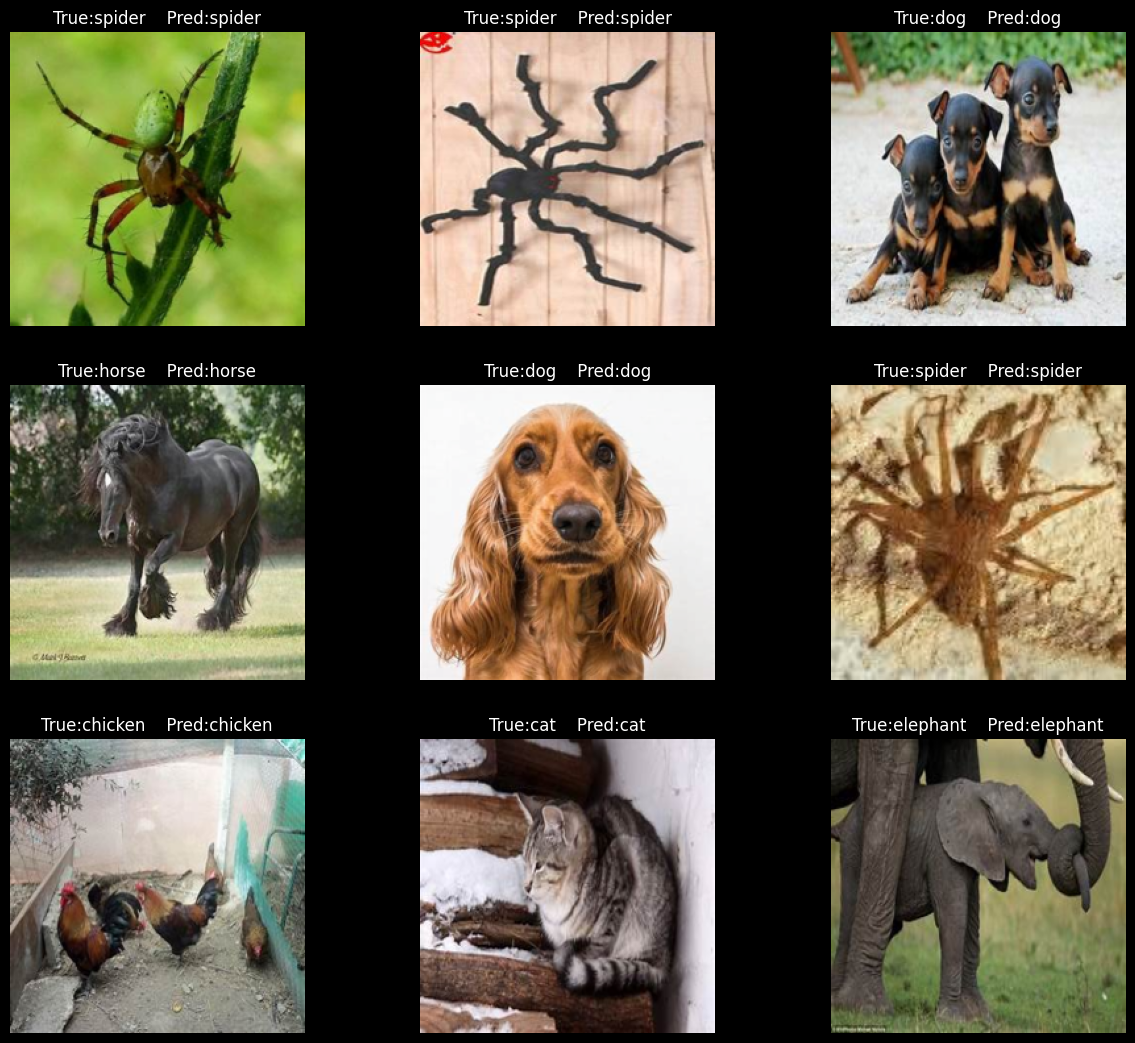

In [35]:
# 假设模型已经加载
model.eval()  # 设置模型为评估模式

# 将模型移动到 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 小批次用于可视化，确保数据也在 GPU 上（如果可用）
train_loader2 = DataLoader(train_set, batch_size=9)

plt.figure(figsize=(15, 13))

# 获取小批次数据
inputs, classes = next(iter(train_loader2))

# 确保输入和标签都在同一个设备上
inputs = inputs.to(device)
classes = classes.to(device)

# 前向传播，得到预测结果
preds = model(inputs).argmax(dim=1)

# 开始绘图
for i in range(9):  # 我们有 9 张图像
    ax = plt.subplot(3, 3, i + 1)

    # 将张量转换为可显示的图像
    img = imformat(inputs[i].cpu())  # 移动到 CPU 以便显示

    # 显示图像
    plt.imshow(img)

    try:
        plt.title(
            "True:"
            + str(t_inv[class_names[classes[i].item()]])
            + "    Pred:"
            + str(t_inv[class_names[preds[i].item()]])
        )
    except:
        plt.title(
            "True:"
            + str(translate[class_names[classes[i].item()]])
            + "    Pred:"
            + str(translate[class_names[preds[i].item()]])
        )

    plt.axis("off")

plt.show()

In [36]:
# train_loader2 = DataLoader(train_set, batch_size=9)

# plt.figure(figsize=(15, 13))

# inputs, classes = next(iter(train_loader2))

# preds = model(inputs).argmax(dim=1)

# if torch.cuda.is_available() == True:
#     inputs = inputs.cuda()
#     classes = classes.cuda()

# for i in range(0, 9):
#     ax = plt.subplot(3, 3, i + 1)
#     img = imformat(inputs[i])

#     plt.imshow((img))

#     try:
#         plt.title(
#             "True:"
#             + str(t_inv[class_names[classes[i]]])
#             + "    Pred:"
#             + str(t_inv[class_names[preds[i]]])
#         )
#     except:
#         plt.title(
#             "True:"
#             + str(translate[class_names[classes[i]]])
#             + "    Pred:"
#             + str(translate[class_names[preds[i]]])
#         )
#     if i == 9:
#         plt.axis("off")

In [34]:
losses = list()
accuracies = list()
model.eval()
for batch in test_loader:
    x, y = batch
    if torch.cuda.is_available() == True:
        x = x.cuda()
        y = y.cuda()

    with torch.no_grad():
        l = model(x)

    # compute the cost function
    J = loss(l, y)

    losses.append(J.item())
    accuracies.append(y.eq(l.detach().argmax(dim=1)).float().mean())

print(f"test loss: {torch.tensor(losses).mean():.2f}", end=", ")
print(f"test accuracy: {torch.tensor(accuracies).mean():.2f}")

test loss: 0.10, test accuracy: 0.97


# VGG16
